In [3]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import pandas as pd
import pyproj
import seaborn as sns
import shapely
from geopy import distance

In [20]:
DaytonDf = pd.read_csv("13/Dayton.csv")
roadNetwork = osmnx.io.load_graphml("data/road.graphml")
study_area = osmnx.geocode_to_gdf("Dayton")

In [5]:
DaytonDf.columns

Index(['Unnamed: 0', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [21]:
nodes, edges = osmnx.graph_to_gdfs(roadNetwork)

In [22]:
buffer = 1
minX = min(nodes["x"]) - buffer
maxX = max(nodes["x"]) + buffer
minY = min(nodes["y"]) - buffer
maxY = max(nodes["y"]) + buffer

In [23]:
DaytonDf = DaytonDf[
    (DaytonDf["Start_Lng"] > minX)
    & (DaytonDf["Start_Lng"] < maxX)
    & (DaytonDf["Start_Lat"] > minY)
    & (DaytonDf["Start_Lat"] < maxY)
]

In [24]:
DaytonDf.shape[0]

23414

In [25]:
DaytonDf["start_coordinate"] = DaytonDf.apply(
    lambda x: shapely.Point(x["Start_Lng"], x["Start_Lat"]), axis=1
)

In [26]:
edges["buffered_geometry"] = edges.copy()["geometry"].apply(
    lambda geom: geom.buffer(0.01)
)

In [27]:
edges["accident_count"] = edges.apply(
    lambda x: len(
        DaytonDf[x["buffered_geometry"].intersects(DaytonDf["start_coordinate"])]
    ),
    axis=1,
)

In [30]:
place_name = "Dayton, Ohio, USA"

# define the tag you're looking for
tags = {"shop": "alcohol"}

# query OSM
alcohol_shops = osmnx.features_from_place(place_name, tags)

<Axes: >

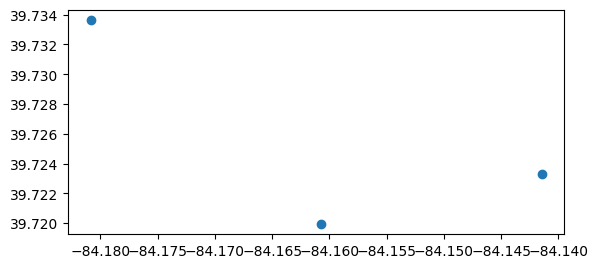

In [53]:
alcohol_shops_polygons_centroids.plot()

/tmp/ipykernel_567062/2827586099.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  alcohol_shops_polygons_centroids['geometry'] = alcohol_shops_polygons_centroids['geometry'].centroid


                     geometry addr:city addr:housenumber addr:postcode  \
0  POINT (-84.13716 39.75249)    Dayton             1024         45403   
1  POINT (-84.18086 39.73362)       NaN              NaN           NaN   
2  POINT (-84.16078 39.71993)       NaN              NaN           NaN   
3  POINT (-84.14146 39.72327)       NaN              NaN           NaN   

  addr:state            addr:street  check_date drive_through  \
0         OH  South Smithville Road  2024-12-26            no   
1        NaN                    NaN         NaN           NaN   
2        NaN                    NaN         NaN           NaN   
3        NaN                    NaN         NaN           NaN   

                     name                      opening_hours            phone  \
0          Smith's Liquor  Mo-Sa 09:00-23:00; Su 11:00-23:00  +1-937-256-2122   
1               Beer Cave                                NaN              NaN   
2  Kwik-n-Kold Drive Thru                                NaN

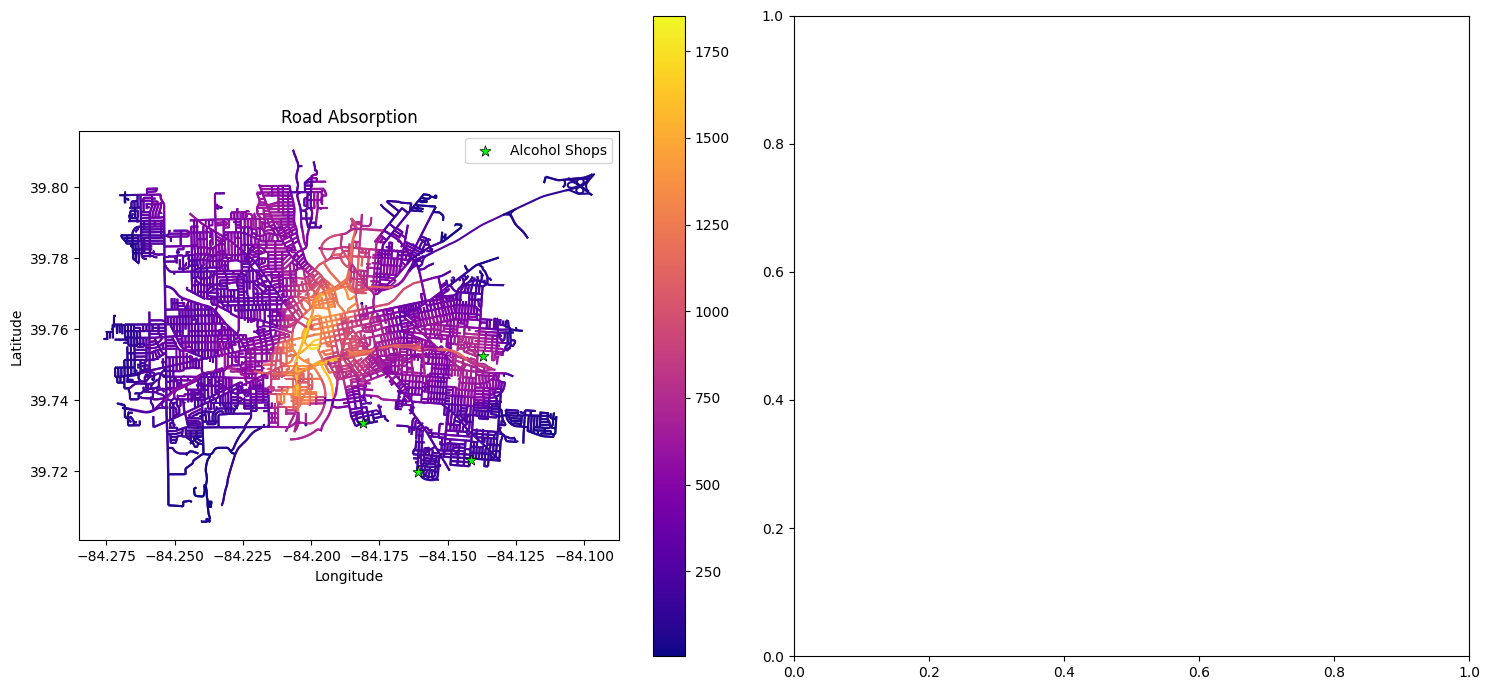

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot absorption
edges.plot(column="accident_count", cmap="plasma", legend=True, ax=axes[0], zorder=1)
axes[0].set_title("Road Absorption")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Separate alcohol shops
alcohol_shops_points = alcohol_shops[alcohol_shops.geometry.type == "Point"]
alcohol_shops_polygons = alcohol_shops[
    alcohol_shops.geometry.type.isin(["Polygon", "MultiPolygon"])
]

# Convert polygons to centroids
alcohol_shops_polygons_centroids = alcohol_shops_polygons.copy()
alcohol_shops_polygons_centroids["geometry"] = alcohol_shops_polygons_centroids[
    "geometry"
].centroid

# Combine all Points (original + centroids)
all_alcohol_shops = gpd.GeoDataFrame(
    pd.concat(
        [alcohol_shops_points, alcohol_shops_polygons_centroids], ignore_index=True
    )
)

# IMPORTANT: assign CRS
all_alcohol_shops = all_alcohol_shops.to_crs(alcohol_shops.crs)
print(all_alcohol_shops)
# Plot all alcohol shops as stars
all_alcohol_shops.plot(
    ax=axes[0],
    color="lime",
    markersize=70,
    marker="*",
    edgecolor="black",
    linewidth=0.5,
    label="Alcohol Shops",
    zorder=5,
)

axes[0].legend()

plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence.

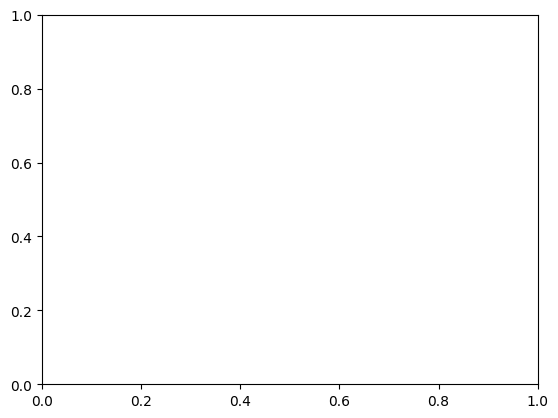

In [51]:
plt.plot(edges["buffered_geometry"])